# **Блокнот до хакатону INT20H**

### Імпорт бібліотек

In [40]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core import display as ICD

### Завантаження даних

In [41]:
data = pd.read_csv("int20h-ds-test-dataset.csv")

### Функція попередньої обробки даних:
* #### Прибирання дублікатів
* #### Приведення дат до одного формату
+ #### Об'єднанння подій та атрибутів з майже однаковими назвами та однаковим сенсом.

In [42]:
def replace_dict(attr, replacing):
    for now, rep in replacing.items():
        attr = attr.replace(now, rep)
    return attr

def data_preprocessing(data):
  data.drop_duplicates(inplace=True)
  data['event_created_date'] = pd.to_datetime(data['event_created_date'], infer_datetime_format=True)
  replace_attr = {'Rental state':'Rental State',
                    'Transaction type':'Transaction Type',
                    'account_history':'Account History',
                    'Phone number':'Phone Number',
                    'Address details':'Address Details'}   
  data['event_attributes'] = data['event_attributes'].map(lambda x: replace_dict(x, replace_attr))
  replace_event_name = {'Account Setup Profile Skip':'Account Setup Skip', 
                        'Chat Conversation Started':'Chat Conversation Opened', 
                        'Add Vehicle Failed':'Add Vehicle Break', 
                        'Subscription Premium Renew':'Subscription Premium'}
  data['event_name'] = data['event_name'].replace(replace_event_name)
    
data_preprocessing(data)

In [43]:
data[['event_attributes']]

,event_attributes
0,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi..."
1,{}
2,{}
3,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}"
4,"{""Method"":""Apple""}"
...,...
23352,"{""Payment Method"":""Credit"",""Tokenized Pay"":"""",..."
23353,"{""Screen"":""Address""}"
23354,"{""Screen"":""Phone Number""}"
23355,"{""From"":""Dashboard"",""Transaction Type"":""""}"


*Із самого початку функція вибору останніх дій клієнта обирала n останніх дій, але нас більше цікавить не дія, яка була зроблена 2 тижні тому (наприклад, людина не користувалася додатком два тижні, а потім зайшла і відмінила підписку), а ді, які були зроблені протягом декількох годин до її відміни.*

### Функції для отримання даних клієнта за заданий час до відміни підписки або покупки підписки відповідно.

До функцій передається датафрейм з даними my_df, набір даних обраного користувача х, кількість годин hour та назва обраної  колонки таблиці col.

Обираються всі унікальні значення колонки, з них обираються ті, що знаходяться між покупкою та відміною (для другої функції - між покупкою та попередньою відміною, якщо така існує). З них обирються дані, що були зроблені в заданий час до відміни/покупки.

In [44]:
all_event_names = data["event_name"].unique()

In [45]:
def get_order_time_df_col(my_df, x, hour, col):
    all_unique_values = my_df[col].unique()
    index_buy = x[x == 'Subscription Premium'].index
    index_cancel = x[x == 'Subscription Premium Cancel'].index
    if not index_buy.shape[0]:
        index_buy = np.array([x.index[0]])

    incorrect_order = np.array([np.all(index_buy < i) for i in index_cancel])
    if np.any(incorrect_order):
        index_cancel = index_cancel[:incorrect_order.argmax()+1]

    df_user = my_df.loc[x.index]
    delta = [(df_user.loc[i, 'event_created_date'] - df_user.loc[index_buy[index_buy < i][-1]:i, 'event_created_date'][1:-1]) / pd.Timedelta('1 hour') < hour for i in index_cancel]
    main_dicti = []
    for i, idx in enumerate(index_cancel):
        dicti = dict(zip(all_unique_values, [0 for _ in range(len(all_unique_values))]))
        for event in df_user[col].loc[index_buy[index_buy < idx][-1]:idx][1:-1][delta[i]]:
            dicti[event] = 1
        main_dicti += [dicti]   
        
    return pd.DataFrame(main_dicti, index=[i for i in range(len(main_dicti))])


def get_before_subscription_buy_order_time_df_col(my_df, x, hour, col):
    all_unique_values = my_df[col].unique()
    index_buy = x[x == 'Subscription Premium'].index
    index_cancel = x[x == 'Subscription Premium Cancel'].index

    if index_buy[0] == x.index[0]:
        index_buy = index_buy[1:]
        if not index_buy.shape[0]:
            return pd.DataFrame(dict(zip(all_unique_values, [0 for _ in range(len(all_unique_values))])), index=[0])

    incorrect_order = np.array([np.all(index_cancel < i) for i in index_buy])
    if np.any(incorrect_order):
        index_cancel = index_cancel[:incorrect_order.argmax()+1]
        
    if not index_cancel.shape[0] or index_cancel[0] > index_buy[0]:
        index_cancel = np.append([x.index[0]], index_cancel)

    if index_cancel[-1]>index_buy[-1]:
        index_cancel = index_cancel[:-1]
    
    df_user = my_df.loc[x.index]
    delta = [(df_user.loc[i, 'event_created_date'] - df_user.loc[index_cancel[index_cancel < i][-1]:i, 'event_created_date'][:-1]) / pd.Timedelta('1 hour') <= hour for i in index_buy]
    
    main_dicti = []
    for i, idx in enumerate(index_buy):
        dicti = dict(zip(all_unique_values, [0 for _ in range(len(all_unique_values))]))
        for event in df_user[col].loc[index_cancel[index_cancel < idx][-1]:idx][:-1][delta[i]]:
            dicti[event] = 1
        main_dicti += [dicti]
    return pd.DataFrame(main_dicti, index=[i for i in range(len(main_dicti))])

### Функція, призначена для отримання атрибутів заданої події та списків їх унікальних значень.

In [46]:
def get_event_attributes_dict(my_df, event_name):
    selected_data=my_df[my_df.event_name==event_name]
    selected_dicts=[json.loads(e) for e in selected_data.event_attributes]
    keyset=set(key for d in selected_dicts for key in d.keys())
    result={key:list(set(dicti[key] if key in dicti else np.nan for dicti in selected_dicts)) for key in keyset}
    return result

### Функції отримання атрибутів подій користувача, зроблених за певний час до відміни підписки, чи до покупки підписки відповідно.

До функцій передається датафрейм з даними my_df, набір даних обраного користувача х, кількість годин hour та назва обраної  події event_name.

Обираються всі унікальні значення атрибутів, з них обираються ті, що знаходяться між відміною та покупкою (для другої функції - між покупкою та попередньою відміною, якщо така існує). З них обирються дані, що були зроблені в заданий час до відміни/покупки.

In [47]:
def get_order_attributes_time_df(my_df, x, hour, event_name):
    event_attributes_dict = get_event_attributes_dict(my_df, event_name)
    values_unpacked = set(j for i in event_attributes_dict.values() for j in i)
    index_buy = x[x == 'Subscription Premium'].index
    index_cancel = x[x == 'Subscription Premium Cancel'].index
    if not index_buy.shape[0]:
        index_buy = np.array([x.index[0]])

    incorrect_order = np.array([np.all(index_buy < i) for i in index_cancel])
    if np.any(incorrect_order):
        index_cancel = index_cancel[:incorrect_order.argmax()+1]

    df_user = my_df.loc[x.index]
    delta = [(df_user.loc[i, 'event_created_date'] - df_user.loc[index_buy[index_buy < i][-1]:i, 'event_created_date'][1:-1]) / pd.Timedelta('1 hour') < hour for i in index_cancel]
    main_dicti = []
    for i, idx in enumerate(index_cancel):        
        events_names = x.loc[index_buy[index_buy < idx][-1]:idx][1:-1][delta[i]]
        indexes = events_names.index
        for event, index in zip(events_names, indexes):
            if event_name==event:
                dicti = dict(zip(values_unpacked, [0 for _ in values_unpacked]))
                atributes_dicti = json.loads(my_df.loc[index, 'event_attributes'])
                for q in atributes_dicti:
                    dicti[atributes_dicti[q]]=1
                main_dicti += [dicti]   
    return pd.DataFrame(main_dicti, index=[i for i in range(len(main_dicti))])

def get_before_subscription_buy_order_attributes_time_df(my_df, x, hour, event_name):
    event_attributes_dict = get_event_attributes_dict(my_df, event_name)
    values_unpacked = set(j for i in event_attributes_dict.values() for j in i)

    index_buy = x[x == 'Subscription Premium'].index
    index_cancel = x[x == 'Subscription Premium Cancel'].index
    dicti = dict(zip(values_unpacked, [0 for _ in range(len(all_event_names))]))

    if index_buy[0] == x.index[0]:
        index_buy = index_buy[1:]
        if not index_buy.shape[0]:
            return pd.DataFrame(dicti, index=[0])

    arr = np.array([np.all(index_cancel < i) for i in index_buy])
    if np.any(arr):
        index_cancel = index_cancel[:arr.argmax()+1]
        
    if not index_cancel.shape[0] or index_cancel[0] > index_buy[0]:
        index_cancel = np.append([x.index[0]], index_cancel)

    if index_cancel[-1]>index_buy[-1]:
        index_cancel = index_cancel[:-1]
    
    df_user = my_df.loc[x.index]
    delta = [(df_user.loc[i, 'event_created_date'] - df_user.loc[index_cancel[index_cancel < i][-1]:i, 'event_created_date'][:-1]) / pd.Timedelta('1 hour') <= hour for i in index_buy]
    
    main_dicti = []
    for i, idx in enumerate(index_buy):
        events_names = x.loc[index_cancel[index_cancel < idx][-1]:idx][:-1][delta[i]]
        indexes = events_names.index
        for event, index in zip(events_names, indexes):
            if event_name == event:
                dicti = dict(zip(values_unpacked, [0 for _ in values_unpacked]))
                atributes_dicti = json.loads(my_df.loc[index, 'event_attributes'])
                for q in atributes_dicti:
                    dicti[atributes_dicti[q]]=1
                main_dicti += [dicti]

    return pd.DataFrame(main_dicti, index=[i for i in range(len(main_dicti))])

### Отримання кількості тих чи інших атрибутів event користувачів за певний час до відміни підписки.
Функція приймає такі атрибути, як event_name - назву оброблюваної події, my_df - набір даних, з якого беремо інформацію, hour - кількість годин, за які обираємо дані, with_corr - чи треба повертати кореляцію.

In [48]:
def get_attributes_dataframe(event_name, my_df=data, hour=2, with_corr=True):
    attributes_df = my_df.copy()
    attributes_users_cancel = attributes_df[attributes_df['userid'].isin(attributes_df.loc[attributes_df['event_name'].isin(['Subscription Premium Cancel']), 'userid'])].sort_values(['event_created_date'])
    attributes_events_cancel = attributes_users_cancel.groupby('userid')['event_name'].apply(lambda x: get_order_attributes_time_df(attributes_df, x, hour, event_name))
    attributes_events_cancel = attributes_events_cancel.reset_index(level=[0,1]).drop('level_1', axis=1)
    attributes_events_cancel['Subscription Premium Cancel'] = 1
    attributes_events_cancel['Subscription Premium'] = 0

    attributes_users_buy = attributes_df[attributes_df['userid'].isin(attributes_df.loc[attributes_df['event_name'].isin(['Subscription Premium']), 'userid'])].sort_values(['event_created_date'])
    attributes_events_buy = attributes_users_buy.groupby('userid')['event_name'].apply(lambda x: get_before_subscription_buy_order_attributes_time_df(attributes_df, x, 2, event_name))
    attributes_events_buy = attributes_events_buy.reset_index(level=[0,1]).drop('level_1', axis=1)
    attributes_events_buy['Subscription Premium'] = 1
    attributes_events_buy['Subscription Premium Cancel'] = 0

    attributes_all_events = pd.concat([attributes_events_cancel,attributes_events_buy], ignore_index=True)
    if with_corr:
        return np.round(attributes_all_events.corr()[['Subscription Premium Cancel']].sort_values('Subscription Premium Cancel'), 3)
    return attributes_all_events

### Отримання кількості тих чи інших дій, зроблених користувачем за певний час до відміни підписки.
Функція приймає такі аргументияк column_name - назва досліджуваної колонки, my_df - набір даних, з якого вибираємо інформацію, hour - кількість годин, за які вибираємо доні, with_corr - чи треба повертати кореляцію. 

In [49]:
def get_events_dataframe(column_name='event_name', my_df=data, hour=2, with_corr=True):
    df = my_df.copy()
    users_cancel = df[df['userid'].isin(df.loc[df['event_name'].isin(['Subscription Premium Cancel']), 'userid'])].sort_values(['event_created_date'])
    events_cancel = users_cancel.groupby('userid')['event_name'].apply(lambda x: get_order_time_df_col(df, x, hour, column_name))
    events_cancel = events_cancel.reset_index(level=[0,1]).drop('level_1', axis=1)
    events_cancel['Subscription Premium Cancel'] = 1
    events_cancel['Subscription Premium'] = 0

    users_buy = df[df['userid'].isin(df.loc[df['event_name'].isin(['Subscription Premium']), 'userid'])].sort_values(['event_created_date'])
    events_buy = users_buy.groupby('userid')['event_name'].apply(lambda x: get_before_subscription_buy_order_time_df_col(df, x, hour, column_name))
    events_buy = events_buy.reset_index(level=[0,1]).drop('level_1', axis=1)
    events_buy['Subscription Premium'] = 1
    events_buy['Subscription Premium Cancel'] = 0

    all_events = pd.concat([events_cancel,events_buy], ignore_index=True)
    if with_corr:
        return np.round(all_events.corr()[['Subscription Premium Cancel']].sort_values('Subscription Premium Cancel'), 3)
    return all_events

### Отримання кореляції подій користувача з відміною підписки.
Отримуємо кореляцію подій, перейменовуємо колонки, візуалізуємо кореляцію.

In [50]:
corr_cancel = get_events_dataframe().rename(columns={'Subscription Premium Cancel':'Correlation'}).iloc[1:-1]
corr_cancel

,Correlation
Add Payment Method Success,-0.532
Sign Up Success,-0.467
Add Vehicle Success,-0.451
Email Confirmation Success,-0.171
Add Payment Method Failed,-0.096
Add Vehicle Break,-0.058
Account Setup Skip,-0.050
Sign Up Error,-0.014
Reset Password Set,-0.014
Calculator Used,0.030


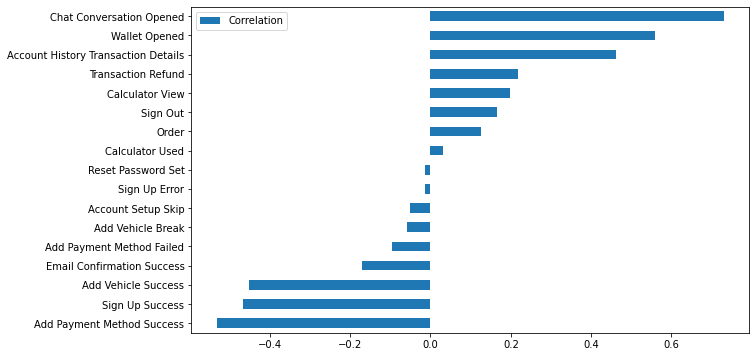

In [51]:
corr_cancel.plot(kind='barh', figsize=(10, 6))
plt.show()

### Отримання кореляції атрибутів подій користувача з відміною підписки.

In [52]:
arr = np.setdiff1d(data['event_name'].unique(), ['Subscription Premium', 'Subscription Premium Cancel'])
arr = arr[[len(get_event_attributes_dict(data, i))!=0 for i in arr]]
ICD.display(pd.DataFrame(arr))

for event_name in arr:
    frame = get_attributes_dataframe(event_name).dropna().iloc[1:-1]
    frame = frame.rename(columns={'Subscription Premium Cancel':'Correlation ' + event_name})
    if frame.shape[0]>10:
        ICD.display(frame.iloc[np.r_[:3, (frame.shape[0]-3):frame.shape[0]]])
    elif frame.shape[0]:
        ICD.display(frame)

,0
0,Account History Transaction Details
1,Account Setup Skip
2,Add Payment Method Failed
3,Add Payment Method Success
4,Add Vehicle Break
5,Add Vehicle Success
6,Calculator Used
7,Chat Conversation Opened
8,Email Confirmation Success
9,Order


,Correlation Account History Transaction Details
Overdue,0.042
Violation Transaction,0.042
Manual Payment,0.060
Forced Payment,0.085
Order,0.144
Pro Plan Subscription,0.177
Pending,0.234
Paid,0.238
Auto Payment,0.322
Account History,0.818


,Correlation Account Setup Skip
Address,-0.004
Phone Number,0.061
Name,0.254
Address Details,0.365


,Correlation Add Payment Method Failed
Credit Card,-0.148
,-0.055
ERROR-NaN10,-0.040
Apple Pay,-0.037
Payment method failed verification.,-0.034
CVV must be 4 digits for American Express and 3 digits for other card types.,-0.017
"Postal code can only contain letters, numbers, spaces, and hyphens.",-0.010
Card is debit but credit is required.,0.078
ERROR-16010,0.078
Google Pay,0.398


,Correlation Add Payment Method Success
Apple Pay,-0.038
PayPal,-0.036
Credit,-0.025
,0.036
Debit,0.059
Google Pay,0.088


,Correlation Add Vehicle Break
ERROR-NaN10,-0.05
The operation couldn’t be completed. (Company.ErrorResponse error 0.),-0.05


,Correlation Add Vehicle Success
White,-0.043
Silver,-0.036
Toyota,-0.035
Scion,0.351
xB,0.499
Excursion,0.499


,Correlation Calculator Used
false,1.0
One,1.0


,Correlation Chat Conversation Opened
Dashboard,-0.128
,-0.089
OrderAlert,0.024
Deeplink,0.031
Pro Plan Subscription,0.045
AutoPayment,0.051
Transaction Details,0.073
Menu,0.093


,Correlation Email Confirmation Success
true,-0.07


,Correlation Order
True,1.0


,Correlation Sign Out
Manual,0.886


,Correlation Transaction Refund
2d795a386ea1e02252e543886b812a9b,0.208
cbf30aa0674eb25b54c37bed044f220b,0.208


### Отримання кореляції атрибутів користувача, таких як штат та дії.

Отримаємо дані з кожної колонки, опускаючи порожні значення.  

In [53]:
for col in ['user_state', 'event_name', 'event_platform', 'device_manufacture']:
    frame = get_events_dataframe(col).dropna().iloc[1:-1]
    frame = frame.rename(columns={'Subscription Premium Cancel':'Correlation ' + col})
    if frame.shape[0]>10:
        ICD.display(frame.iloc[np.r_[:3, (frame.shape[0]-3):frame.shape[0]]])
    elif frame.shape[0]:
        ICD.display(frame)

,Correlation user_state
NY,-0.037
WI,-0.024
CT,-0.024
IL,0.048
CA,0.060
FL,0.063


,Correlation event_name
Add Payment Method Success,-0.532
Sign Up Success,-0.467
Add Vehicle Success,-0.451
Account History Transaction Details,0.463
Wallet Opened,0.559
Chat Conversation Opened,0.731


,Correlation event_platform
android,0.060
ios,0.065
outofband,0.254


,Correlation device_manufacture
Wingtech,-0.028
TCL,-0.028
motorola,-0.022
Apple,0.065
samsung,0.069
NaN,0.254
